
Quel type de message souhaitez-vous envoyer ?
    Message écrit -> 1

Veuillez sélectionner une réponse valide
Réponse sélectionnée :  1
Texte en binaire :  [0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0]
Résultat CRC : [0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Octet protocole type de fichier :  [1, 1, 0, 0, 0, 0, 1, 1]
Fanion de début :  [1, 1, 1, 1, 1, 1, 1, 1]
Fanion de fin   :  [0, 0, 0, 0, 0, 0, 0, 0]
Trame complète  :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Codage Manchester :  [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,

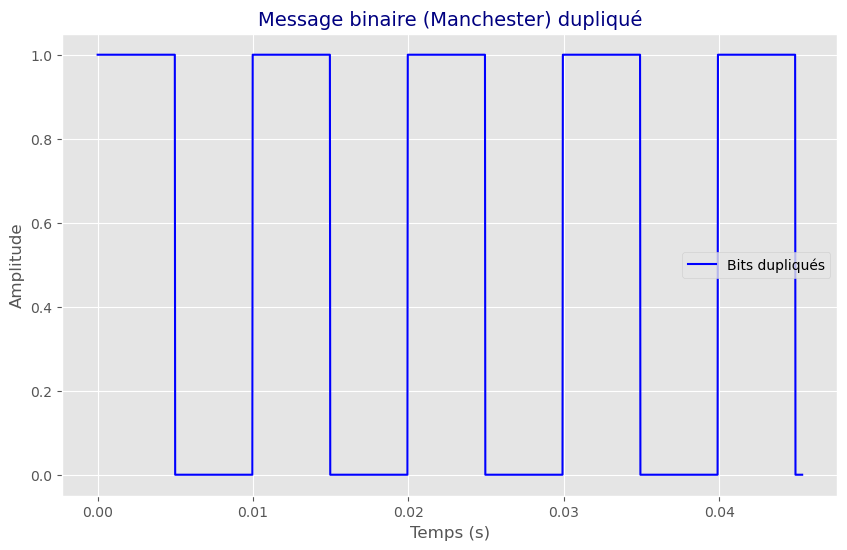

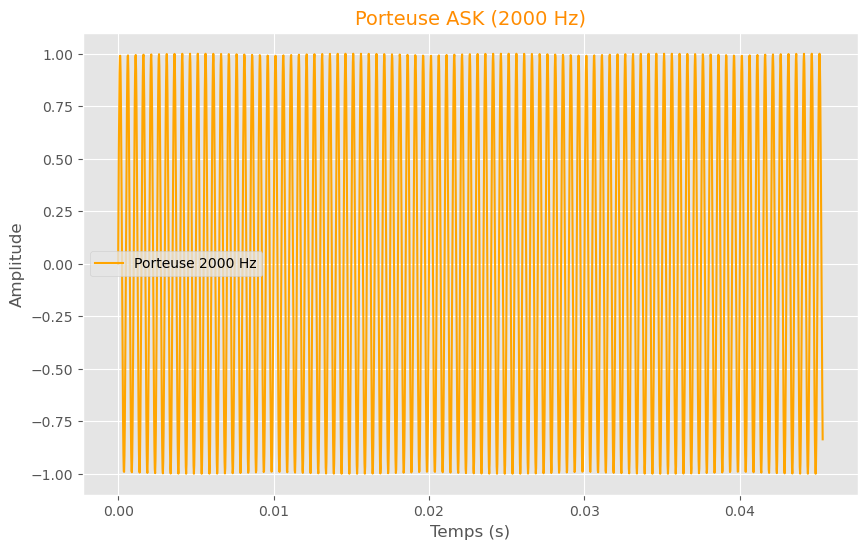

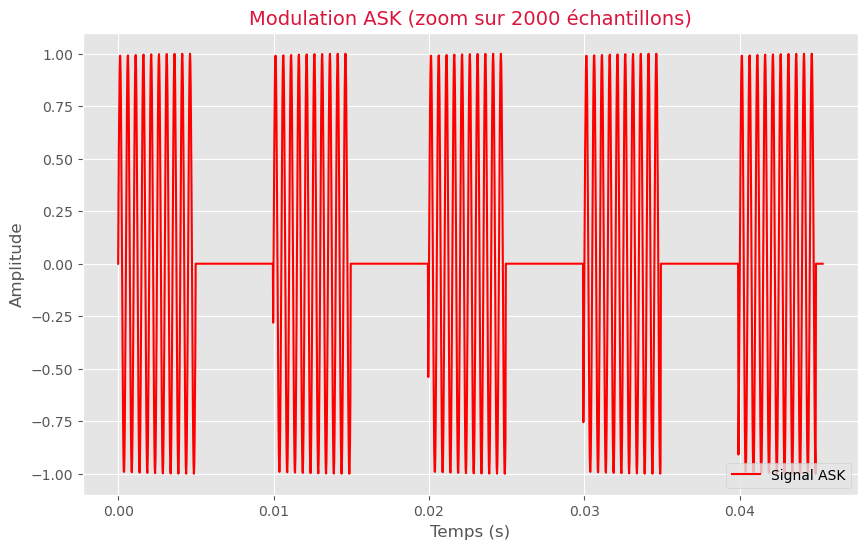

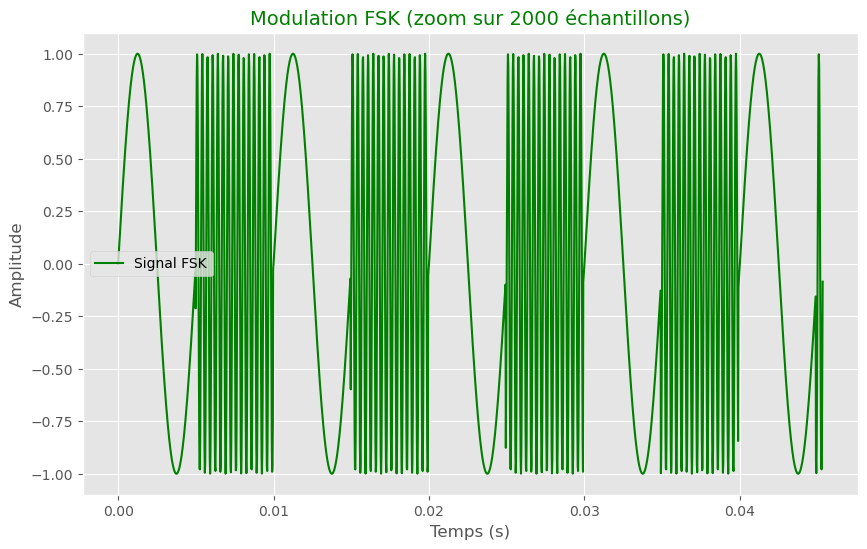

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd

# On utilise un style intégré à Matplotlib : 'ggplot'

plt.style.use('ggplot')

def crcemission(bits):
    """
    Calcul du code CRC sur la liste de bits 'bits'
    à l'aide du diviseur binaire '1001' (soit 9 en décimal).
    """
    diviseur = int("1001", 2)  # 9 en décimal
    resultat_crc = []

    while len(bits) >= 8:
        donne_str = ''.join(map(str, bits[:8]))
        bits = bits[8:]

        donne_str_dividende = donne_str + "0000"
        donne_int_dividende = int(donne_str_dividende, 2)

        quotient, reste = divmod(donne_int_dividende, diviseur)

        donnee_int = format(int(donne_str, 2), '08b')
        resultat_crc.extend(map(int, donnee_int))
        resultat_crc.extend(map(int, format(reste, '04b')))

    print("Résultat CRC :", resultat_crc)
    return resultat_crc

def trame(bits, type_fichier):
    """
    Construction d'une trame :
      - Ajout d'un octet de protocole selon le type de fichier.
      - Fanion de début (8 bits = 11111111).
      - Fanion de fin  (8 bits = 00000000).
    """
    prot_txt = [1,1,0,0,0,0,1,1]
    if type_fichier == "txt":
        bits = prot_txt + bits
        print("Octet protocole type de fichier : ", prot_txt)

    fanion_debut = [1,1,1,1,1,1,1,1]
    fanion_fin   = [0,0,0,0,0,0,0,0]

    bits = fanion_debut + bits + fanion_fin
    print("Fanion de début : ", fanion_debut)
    print("Fanion de fin   : ", fanion_fin)
    print("Trame complète  : ", bits)

    return bits

def Manchester(bits):
    """
    Codage de ligne Manchester :
      - 1 -> (1, 0)
      - 0 -> (0, 1)
    """
    manchester = []
    for b in bits:
        if b == 1:
            manchester.append(1)
            manchester.append(0)
        else:
            manchester.append(0)
            manchester.append(1)
    print("Codage Manchester : ", manchester)
    return manchester

def ASKetFSK(ASK_manchester):
    """
    Génération de deux modulations :
      - ASK (Amplitude Shift Keying)
      - FSK (Frequency Shift Keying)
    Puis lecture audio via sounddevice.
    """
    Fe    = 44100            # Fréquence d'échantillonnage
    baud  = 200              # Débit binaire (bit/s)
    Nbits = len(ASK_manchester)
    Ns    = int(Fe / baud)   # Nb d'échantillons par bit
    N     = Nbits * Ns

    t = np.arange(N) / Fe

    # Porteuse ASK à 2000 Hz
    porteuse_ASK = np.sin(2 * np.pi * 2000 * t)

    # On duplique les bits pour correspondre au nombre d'échantillons
    bits_dupliques = np.repeat(ASK_manchester, Ns)

    # Modulation ASK
    ASK = bits_dupliques * porteuse_ASK

    # Modulation FSK
    fp1 = 200
    fp2 = 3000
    P1  = np.sin(2 * np.pi * fp1 * t)
    P2  = np.sin(2 * np.pi * fp2 * t)
    FSK = np.where(bits_dupliques == 1, P1, P2)

    # Sauvegardes en CSV (optionnel)
    np.savetxt("Message_ASK.csv", ASK, fmt='%.6f', delimiter=',')
    np.savetxt("Message_FSK.csv", FSK, fmt='%.6f', delimiter=',')

    print("Signal modulé (ASK) : ", ASK[:10], "...")
    print("Signal modulé (FSK) : ", FSK[:10], "...")

    # Lecture audio (ASK puis FSK)
    sd.play(ASK, Fe)
    sd.wait()
    sd.play(FSK, Fe)
    sd.wait()

    # -- Graphes personnalisés avec ggplot style --

    # 1) Bits dupliqués
    plt.figure(figsize=(10,6))
    plt.plot(t[:2000], bits_dupliques[:2000],
             color='blue', linewidth=1.5, label='Bits dupliqués')
    plt.title("Message binaire (Manchester) dupliqué", fontsize=14, color='navy')
    plt.xlabel("Temps (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.legend()
    plt.grid(True)

    # 2) Porteuse ASK
    plt.figure(figsize=(10,6))
    plt.plot(t[:2000], porteuse_ASK[:2000],
             color='orange', linewidth=1.5, label='Porteuse 2000 Hz')
    plt.title("Porteuse ASK (2000 Hz)", fontsize=14, color='darkorange')
    plt.xlabel("Temps (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.legend()
    plt.grid(True)

    # 3) Modulation ASK
    plt.figure(figsize=(10,6))
    plt.plot(t[:2000], ASK[:2000],
             color='red', linewidth=1.5, label='Signal ASK')
    plt.title("Modulation ASK (zoom sur 2000 échantillons)", fontsize=14, color='crimson')
    plt.xlabel("Temps (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.legend()
    plt.grid(True)

    # 4) Modulation FSK
    plt.figure(figsize=(10,6))
    plt.plot(t[:2000], FSK[:2000],
             color='green', linewidth=1.5, label='Signal FSK')
    plt.title("Modulation FSK (zoom sur 2000 échantillons)", fontsize=14, color='green')
    plt.xlabel("Temps (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.show()

def message():
    """
    Saisir le message, calcul CRC, trame, Manchester, modulations...
    """
    texte = ""
    while not texte:
        texte = input("Saisissez votre message :\n")

    # Conversion du texte en binaire ASCII (8 bits / caractère)
    texte_bit = []
    for char in texte:
        binaire = format(ord(char), '08b')
        texte_bit.extend(int(i) for i in binaire)

    print("Texte en binaire : ", texte_bit)

    # Calcul du CRC
    texte_bit_crc = crcemission(texte_bit)

    # Création de la trame
    trame_bin = trame(texte_bit_crc, "txt")

    # Codage Manchester
    texte_bit_Manchester = Manchester(trame_bin)

    # Modulation ASK et FSK + lecture audio
    ASKetFSK(texte_bit_Manchester)

# -------------------------------------------------------------------------
#                          Programme principal
# -------------------------------------------------------------------------
print("""
Quel type de message souhaitez-vous envoyer ?
    Message écrit -> 1
""")

suivant = 0
while suivant == 0:
    try:
        reponse = int(input())
        print("Réponse sélectionnée : ", reponse)
        suivant = 1
    except ValueError:
        print("Veuillez sélectionner une réponse valide")

if reponse == 1:
    message()
else:
    print("Réponse invalide")
